In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

df = pd.read_excel('tastytrade2023.xlsx')

Inspecting data

In [6]:
df.head()

,Date,Type,Action,Symbol,Instrument Type,Description,Value,Quantity,Average Price,Commissions,Fees,Multiplier,Root Symbol,Underlying Symbol,Expiration Date,Strike Price,Call or Put,Order #
0,2023-12-19T11:46:25-0500,Trade,SELL_TO_OPEN,LYFT 240119P00012500,Equity Option,Sold 1 LYFT 01/19/24 Put 12.50 @ 0.18,18,1,18,-1,-0.132,100,LYFT,LYFT,2024-01-19,12.5,PUT,300038740
1,2023-12-19T10:36:49-0500,Trade,BUY_TO_CLOSE,MARA 240119P00011000,Equity Option,Bought 1 MARA 01/19/24 Put 11.00 @ 0.11,-11,1,-11,0,-0.120,100,MARA,MARA,2024-01-19,11.0,PUT,299597885
2,2023-12-18T14:56:43-0500,Trade,SELL_TO_OPEN,PARA 240119P00013000,Equity Option,Sold 1 PARA 01/19/24 Put 13.00 @ 0.20,20,1,20,-1,-0.132,100,PARA,PARA,2024-01-19,13.0,PUT,299906059
3,2023-12-18T14:31:12-0500,Trade,SELL_TO_OPEN,RUN 240119P00013000,Equity Option,Sold 1 RUN 01/19/24 Put 13.00 @ 0.26,26,1,26,-1,-0.132,100,RUN,RUN,2024-01-19,13.0,PUT,299897986
4,2023-12-15T15:47:44-0500,Trade,SELL_TO_OPEN,DKNG 240119P00030000,Equity Option,Sold 1 DKNG 01/19/24 Put 30.00 @ 0.27,27,1,27,-1,-0.132,100,DKNG,DKNG,2024-01-19,30.0,PUT,299724751


Splitting date into date and time

In [7]:
df.columns = df.columns.str.lower()
df['time'] = df.date.apply(lambda x : x.split('T')[-1])
df['date'] = df.date.apply(lambda x : x.split('T')[0])
df['date'] = pd.to_datetime(df['date'])

Creating strike price id and dte(day till expiration)
   

In [8]:
df['symbol'] = df['symbol'].str.replace(r'\s+', '')
df['dte'] = (df['expiration date'] - df['date']).dt.days
df.head()

C:\Users\jeffr_8w9ayt5\AppData\Local\Temp\ipykernel_33148\913672157.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['symbol'] = df['symbol'].str.replace(r'\s+', '')


,date,type,action,symbol,instrument type,description,value,quantity,average price,commissions,fees,multiplier,root symbol,underlying symbol,expiration date,strike price,call or put,order #,time,dte
0,2023-12-19,Trade,SELL_TO_OPEN,LYFT240119P00012500,Equity Option,Sold 1 LYFT 01/19/24 Put 12.50 @ 0.18,18,1,18,-1,-0.132,100,LYFT,LYFT,2024-01-19,12.5,PUT,300038740,11:46:25-0500,31
1,2023-12-19,Trade,BUY_TO_CLOSE,MARA240119P00011000,Equity Option,Bought 1 MARA 01/19/24 Put 11.00 @ 0.11,-11,1,-11,0,-0.120,100,MARA,MARA,2024-01-19,11.0,PUT,299597885,10:36:49-0500,31
2,2023-12-18,Trade,SELL_TO_OPEN,PARA240119P00013000,Equity Option,Sold 1 PARA 01/19/24 Put 13.00 @ 0.20,20,1,20,-1,-0.132,100,PARA,PARA,2024-01-19,13.0,PUT,299906059,14:56:43-0500,32
3,2023-12-18,Trade,SELL_TO_OPEN,RUN240119P00013000,Equity Option,Sold 1 RUN 01/19/24 Put 13.00 @ 0.26,26,1,26,-1,-0.132,100,RUN,RUN,2024-01-19,13.0,PUT,299897986,14:31:12-0500,32
4,2023-12-15,Trade,SELL_TO_OPEN,DKNG240119P00030000,Equity Option,Sold 1 DKNG 01/19/24 Put 30.00 @ 0.27,27,1,27,-1,-0.132,100,DKNG,DKNG,2024-01-19,30.0,PUT,299724751,15:47:44-0500,35


Dropping incomplete transactions. (Open happened in 2022 or has not closed yet in 2023)

In [9]:
freq_count = df.symbol.value_counts()
threshold = 1
df1 = df[df['symbol'].isin(freq_count[freq_count > threshold].index)]
df1.symbol.value_counts()

MARA240119P00011000    2
M230421P00015500       2
PLUG230505P00009000    2
MRVL230428P00036000    2
X230505P00022000       2
                      ..
RIVN231006P00018500    2
AMC231020P00004000     2
RUN231006P00013000     2
MARA231006P00009000    2
M230127P00018000       2
Name: symbol, Length: 115, dtype: int64

Splitting data into opening and closing and renaming columns

In [10]:
df_open = df1[df1['action'] == 'SELL_TO_OPEN']
df_close = df1[df1['action'] == 'BUY_TO_CLOSE']
df_close = df_close.copy()
new_columns_close = {'date': 'close_date', 'value': 'close_value', 'fees': 'close_fees', 'dte' : 'close_dte'}
df_close.rename(columns = new_columns_close, inplace= True)
df_open = df_open.copy()
new_columns_open = {'date': 'open_date', 'value': 'open_value', 'fees': 'open_fees', 'dte' : 'open_dte'}
df_open.rename(columns = new_columns_open, inplace=True)

Modifing closing dataframe then merging relevent data to opening creating dataframe of complete transactions

In [11]:
close_columns = ['close_date', 'symbol', 'close_value', 'close_fees', 'close_dte']
df_close = df_close[close_columns]
df_close.head()
df_clean = pd.merge(df_open, df_close, how = 'inner')
df_clean.drop(columns=['type', 'action','instrument type', 'description','quantity', 'average price', 'multiplier','underlying symbol','order #','time'], inplace = True)

In [ ]:
Creating days_held, profit_gross, profit_net.

In [12]:
df_clean['days_held'] = (df_clean['open_dte'] - df_clean['close_dte'])
df_clean['profit_gross'] = (df_clean['open_value'] + df_clean['close_value'])
df_clean['profit_net'] = (df_clean['profit_gross'] + df_clean['commissions'] + df_clean['open_fees'] + df_clean['close_fees'])
df_clean.head()

,open_date,symbol,open_value,commissions,open_fees,root symbol,expiration date,strike price,call or put,open_dte,close_date,close_value,close_fees,close_dte,days_held,profit_gross,profit_net
0,2023-12-15,MARA240119P00011000,25,-1,-0.132,MARA,2024-01-19,11.0,PUT,35,2023-12-19,-11,-0.12,31,4,14,12.748
1,2023-12-12,X240119P00031000,33,-1,-0.132,X,2024-01-19,31.0,PUT,38,2023-12-14,-15,-0.12,36,2,18,16.748
2,2023-12-06,MARA240112P00010500,28,-1,-0.132,MARA,2024-01-12,10.5,PUT,37,2023-12-14,-13,-0.12,29,8,15,13.748
3,2023-12-04,RIVN240105P00014000,23,-1,-0.132,RIVN,2024-01-05,14.0,PUT,32,2023-12-11,-10,-0.12,25,7,13,11.748
4,2023-12-01,CHWY240105P00015000,83,-1,-0.132,CHWY,2024-01-05,15.0,PUT,35,2023-12-06,-37,-0.12,30,5,46,44.748


Trade Strategy: Most trades this year was selling a put and were meant to follow this rules:
    *Trades are targeted at having a probability of profit between 77% and 85% (around 1 standard deviation of potential movement)
    * A minimum of $20 of profit was the goal for most new open trades.  The goal for any rolled trades was to be positive to recoup some of the losses
    * 55% of profit potential triggers an automatic close   
    * Trades are closed or rolled no less than two weeks before expiration 
    * Trade when the stock price is down for the day
    

Just about 80% of my trades were positive.  For next year I will keep trading in the same probability of profit range of 77% to 85%.

In [14]:
positive_trades = (df_clean['profit_net'] > 0).sum()
total_trades = len(df_clean['profit_net'])
perc_positive_trades = positive_trades/total_trades
print(perc_positive_trades)

0.7964601769911505


15% of trades voliated the rule to close or roll no less than two weeks to expiration.  Of the 17 trades that broke the rule 9 were positive.  Only one trade was held into the last week and did close for profit. I would assume that the trades that went into the last two weeks where far enough into the money that I was not concerned but I do not have the information at the moment to check that.  I will say that for next year if the trade price is more than 20% greater than the strike price I can hold it into the last two weeks and 30% to go into the last week.  Normally with having an auto close triggered at 55% of profit potiential the trade would have closed or have been rolled before this point.  I will need to track the data for that in the upcoming year.   

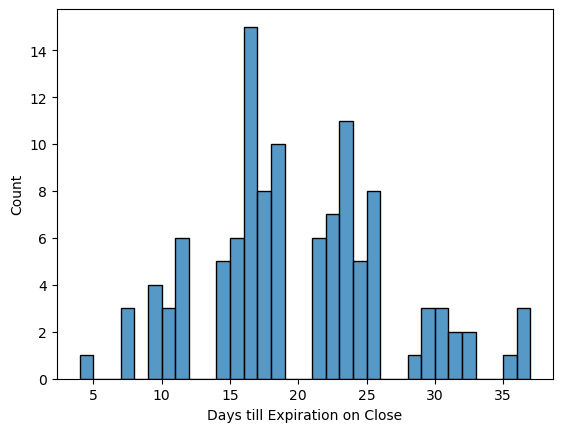

17
9
1
1


In [15]:
sns.histplot(x = 'close_dte', data = df_clean, bins = 33)
plt.xlabel('Days till Expiration on Close')
plt.show()
plt.close()

held_too_long = (df_clean['close_dte'] < 14).sum()
positive_too_long = ((df_clean['profit_net'] > 0) & (df_clean['close_dte'] < 14)).sum()
print(held_too_long)
print(positive_too_long)

held_to_week = (df_clean['close_dte'] < 7).sum()
positive_to_week = ((df_clean['profit_net'] > 0) & (df_clean['close_dte'] < 5)).sum()
print(held_to_week)
print(positive_to_week)


50% of the trades had a profit potential of between $23 and $36.   Only 5 trades were opened below the $20 target goal with 3 of them ending up as a loss.  For the next year I will keep this rule in place. Since I will continue to trade many of the same assets.  I would predict that for the next year though my median profit potential will increase as my account grows and I have the opportunity to trade more valuable contracts.  

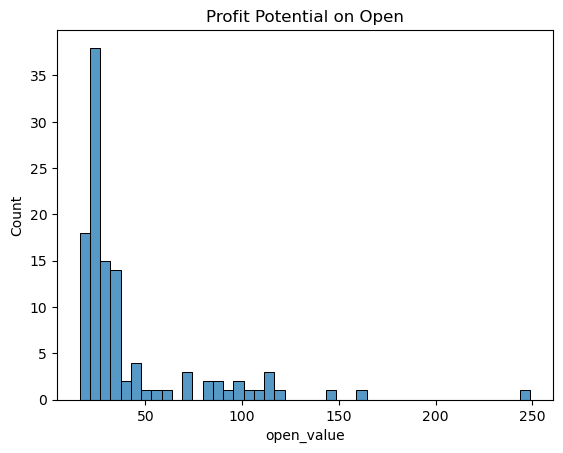

count    113.000000
mean      41.097345
std       35.411853
min       16.000000
25%       23.000000
50%       27.000000
75%       36.000000
max      249.000000
Name: open_value, dtype: float64
0    21
Name: open_value, dtype: int64
21     10
25      8
26      8
22      8
23      7
24      7
27      6
32      6
33      4
30      4
20      3
19      3
28      3
43      2
29      2
34      2
36      2
50      1
91      1
42      1
59      1
115     1
44      1
70      1
161     1
99      1
112     1
73      1
108     1
40      1
16      1
81      1
56      1
45      1
102     1
144     1
83      1
87      1
86      1
249     1
72      1
17      1
97      1
117     1
114     1
Name: open_value, dtype: int64
5
2


In [36]:
sns.histplot(x = 'open_value', data = df_clean)
plt.title('Profit Potential on Open')
plt.show()
plt.close()


below_goal_potential = (df_clean['open_value'] <20).sum() 
below_goal_potential_win = ((df_clean['open_value'] < 20) & (df_clean['profit_gross'] < 0)).sum()
print(df_clean['open_value'].describe())
print(df_clean['open_value'].mode())
print(df_clean['open_value'].value_counts())
print(below_goal_potential)
print(below_goal_potential_win)


Checking for correlation involving time till expiration or days held.  There is no appearent linear relationship.

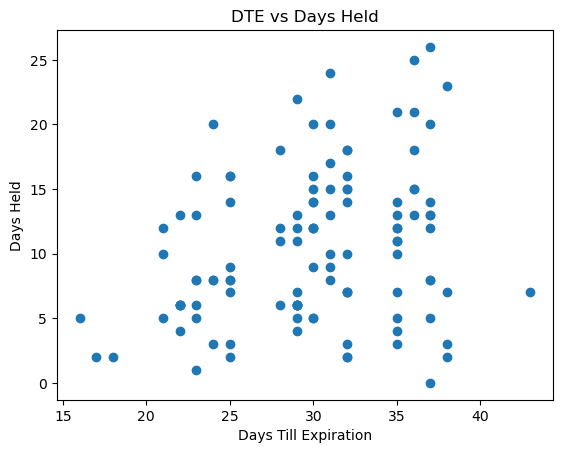

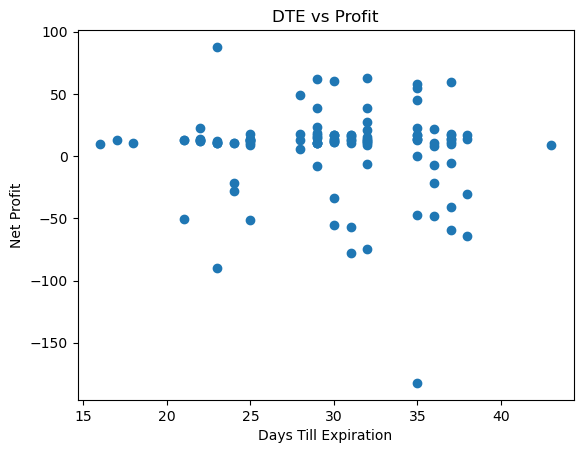

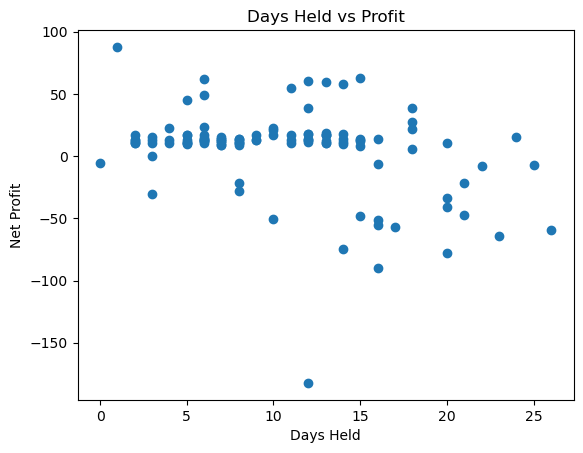

In [37]:
plt.scatter(x = 'open_dte', y = 'days_held', data = df_clean)
plt.xlabel("Days Till Expiration")
plt.ylabel("Days Held")
plt.title("DTE vs Days Held")
plt.show()
plt.close()

plt.scatter(x = 'open_dte', y = 'profit_net', data = df_clean)
plt.xlabel("Days Till Expiration")
plt.ylabel("Net Profit")
plt.title("DTE vs Profit")
plt.show()
plt.close()

plt.scatter(x = 'days_held', y = 'profit_net', data = df_clean)
plt.xlabel("Days Held")
plt.ylabel("Net Profit")
plt.title("Days Held vs Profit")
plt.show()
plt.close()

Exporting Data

In [9]:
df_fin = df_clean
file_path = r'C:\Users\jeffr_8w9ayt5\Desktop\Learning\Projects\trade_analysis_2023\trade2023.xlsx'
df_fin.to_excel(file_path, index = False)